In [86]:
%matplotlib inline
import pandas as pd
import os

# Define file paths
path1 = '../mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/'
path2 = '../mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/'

# List of all unique filenames across both directories
all_files = [
    'dailyActivity_merged.csv',
    'heartrate_seconds_merged.csv',
    'hourlyCalories_merged.csv',
    'hourlyIntensities_merged.csv',
    'sleepDay_merged.csv',
    'weightLogInfo_merged.csv'
]

# Dictionary to store clean dataframes
data = {}

for filename in all_files:
    file_path1 = os.path.join(path1, filename)
    file_path2 = os.path.join(path2, filename)
    
    df_list = []
    
    # Check and load from first directory
    if os.path.exists(file_path1):
        df_list.append(pd.read_csv(file_path1))
        
    # Check and load from second directory
    if os.path.exists(file_path2):
        df_list.append(pd.read_csv(file_path2))
    
    # Merge if data exists
    if df_list:
        combined_df = pd.concat(df_list, ignore_index=True)
        
        # Create clean name (remove _merged.csv)
        clean_name = filename.replace('_merged.csv', '')
        data[clean_name] = combined_df
        
        print(f"Loaded {clean_name}: {combined_df.shape}")
    else:
        print(f"Warning: {filename} not found in either directory.")

# Clean up keys for easier access (optional: create individual variables)
# locals().update(data) # Uncomment to create variables like dailyActivity, heartrate_seconds etc.

print("\nAll files loaded successfully into 'data' dictionary.")

Loaded dailyActivity: (1397, 15)
Loaded heartrate_seconds: (3638339, 3)
Loaded hourlyCalories: (46183, 3)
Loaded hourlyIntensities: (46183, 4)
Loaded sleepDay: (413, 5)
Loaded weightLogInfo: (100, 8)

All files loaded successfully into 'data' dictionary.


In [ ]:
daily_activity = data['dailyActivity']
daily_activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1397 entries, 0 to 1396
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        1397 non-null   int64  
 1   ActivityDate              1397 non-null   object 
 2   TotalSteps                1397 non-null   int64  
 3   TotalDistance             1397 non-null   float64
 4   TrackerDistance           1397 non-null   float64
 5   LoggedActivitiesDistance  1397 non-null   float64
 6   VeryActiveDistance        1397 non-null   float64
 7   ModeratelyActiveDistance  1397 non-null   float64
 8   LightActiveDistance       1397 non-null   float64
 9   SedentaryActiveDistance   1397 non-null   float64
 10  VeryActiveMinutes         1397 non-null   int64  
 11  FairlyActiveMinutes       1397 non-null   int64  
 12  LightlyActiveMinutes      1397 non-null   int64  
 13  SedentaryMinutes          1397 non-null   int64  
 14  Calories

In [ ]:
# To change column names to snake case
import re
import pandas as pd

def to_snake_case(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()


for col in daily_activity.columns:
    daily_activity.rename(columns={col: to_snake_case(col)}, inplace=True)



In [ ]:
# information about the dataset
daily_activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1397 entries, 0 to 1396
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          1397 non-null   int64         
 1   activity_date               1397 non-null   datetime64[ns]
 2   total_steps                 1397 non-null   int64         
 3   total_distance              1397 non-null   float64       
 4   tracker_distance            1397 non-null   float64       
 5   logged_activities_distance  1397 non-null   float64       
 6   very_active_distance        1397 non-null   float64       
 7   moderately_active_distance  1397 non-null   float64       
 8   light_active_distance       1397 non-null   float64       
 9   sedentary_active_distance   1397 non-null   float64       
 10  very_active_minutes         1397 non-null   int64         
 11  fairly_active_minutes       1397 non-null   int64       

In [90]:
#Date Parsing & Validation

daily_activity["activity_date"] = pd.to_datetime(daily_activity["activity_date"])
daily_activity ["activity_date"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1397 entries, 0 to 1396
Series name: activity_date
Non-Null Count  Dtype         
--------------  -----         
1397 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 11.0 KB


In [91]:
#Duplicate & Logical Integrity Checks
daily_activity.duplicated().sum()

np.int64(0)

In [92]:
# num of unique rows
daily_activity.nunique()

id                              35
activity_date                   62
total_steps                   1208
total_distance                 781
tracker_distance               780
logged_activities_distance      35
very_active_distance           410
moderately_active_distance     243
light_active_distance          591
sedentary_active_distance       10
very_active_minutes            130
fairly_active_minutes           93
lightly_active_minutes         379
sedentary_minutes              684
calories                       995
dtype: int64

In [93]:
#Data Quality & Anomaly Checks

In [130]:
# Zero-Activity Days
(daily_activity["total_steps"] == 0).mean() * 100
(daily_activity["calories"] < 1200).sum()


np.int64(48)

In [ ]:
# consistency check because a day should have 1440 minutes
daily_activity["total_minutes"] = (
    daily_activity["very_active_minutes"]
    + daily_activity["fairly_active_minutes"]
    + daily_activity["lightly_active_minutes"]
    + daily_activity["sedentary_minutes"]
)

daily_activity["total_minutes"].describe()


count    1397.000000
mean     1210.997853
std       279.946248
min         2.000000
25%       988.000000
50%      1440.000000
75%      1440.000000
max      1440.000000
Name: total_minutes, dtype: float64

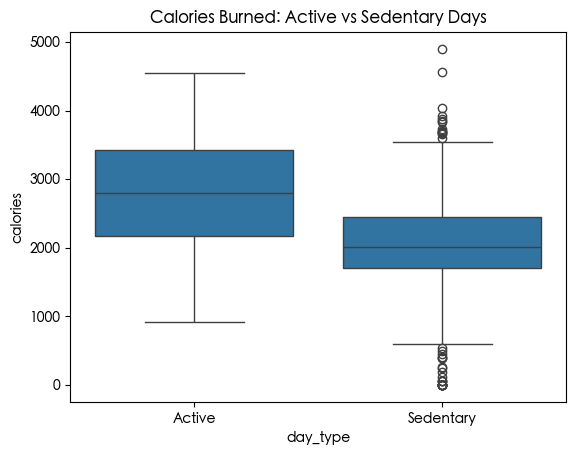

In [ ]:
#Active vs Sedentary Days
daily_activity["day_type"] = np.where(
    daily_activity["very_active_minutes"] >= 30,
    "Active",
    "Sedentary"
)

daily_activity["day_type"].value_counts(normalize=True)

sns.boxplot(
    data=daily_activity,
    x="day_type",
    y="calories"
)
plt.title("Calories Burned: Active vs Sedentary Days")
plt.show()



In [ ]:
# 6. Descriptive Statistics & Distributions

In [101]:
# 6.1 Core Activity Metrics

daily_activity[["total_steps", "total_distance", "calories"]].describe()


,total_steps,total_distance,calories
count,1397.000000,1397.000000,1397.000000
mean,7280.898354,5.219434,2266.265569
std,5214.336113,3.994206,753.005527
min,0.000000,0.000000,0.000000
25%,3146.000000,2.170000,1799.000000
50%,6999.000000,4.950000,2114.000000
75%,10544.000000,7.500000,2770.000000
max,36019.000000,28.030001,4900.000000


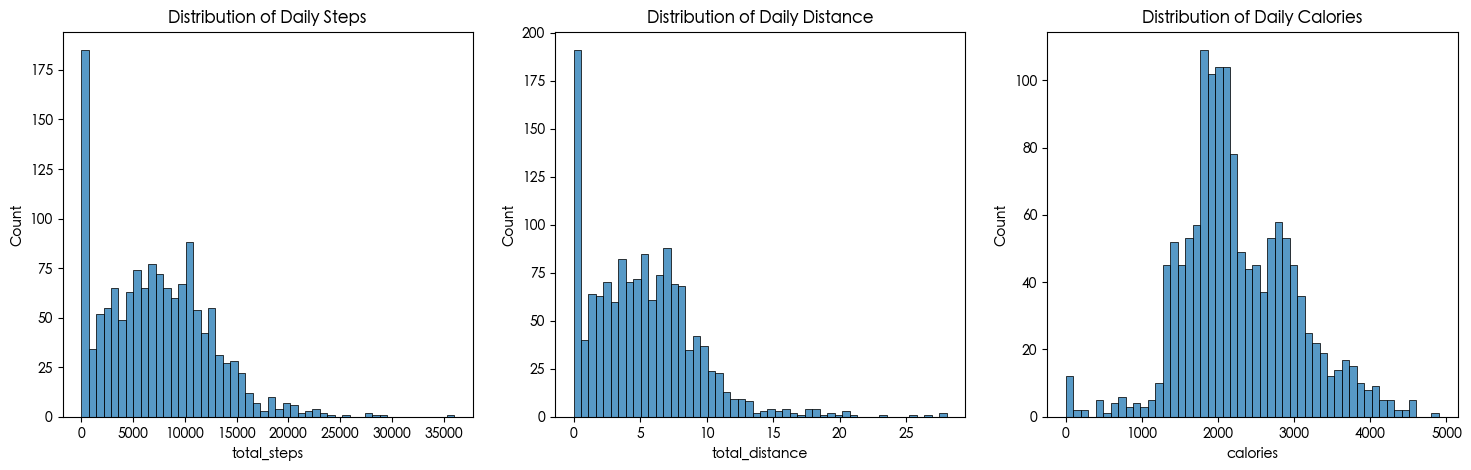

In [ ]:
# distribution histograms
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(daily_activity["total_steps"], bins=50, ax=axes[0])
axes[0].set_title("Distribution of Daily Steps")

sns.histplot(daily_activity["total_distance"], bins=50, ax=axes[1])
axes[1].set_title("Distribution of Daily Distance")

sns.histplot(daily_activity["calories"], bins=50, ax=axes[2])
axes[2].set_title("Distribution of Daily Calories")

plt.show()


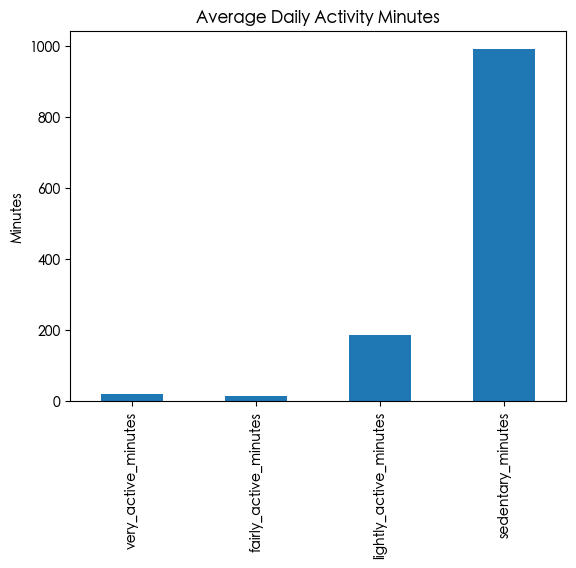

In [115]:
#7. Activity Intensity Breakdown

activity_minutes = daily_activity[
    ["very_active_minutes", "fairly_active_minutes",
     "lightly_active_minutes", "sedentary_minutes"]
].mean()

activity_minutes.plot(kind="bar", title="Average Daily Activity Minutes")
plt.ylabel("Minutes")
plt.show()


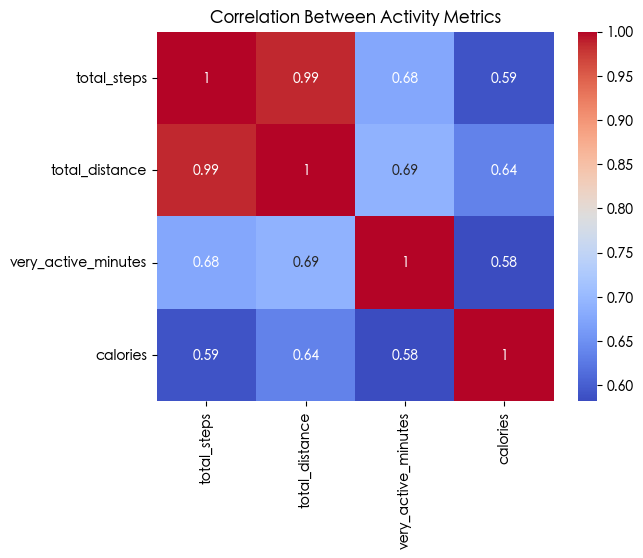

In [117]:
# 8. Relationship & Correlation Analysis
# 8.1 Correlation Matrix

corr = daily_activity[
    ["total_steps", "total_distance", 
     "very_active_minutes", "calories"]
].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Between Activity Metrics")
plt.show()


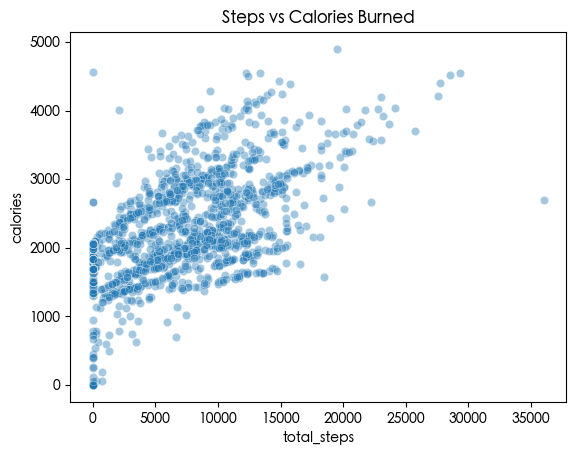

In [118]:
#8.2 Steps vs Calories

sns.scatterplot(x="total_steps", y="calories", data=daily_activity, alpha=0.4)
plt.title("Steps vs Calories Burned")
plt.show()


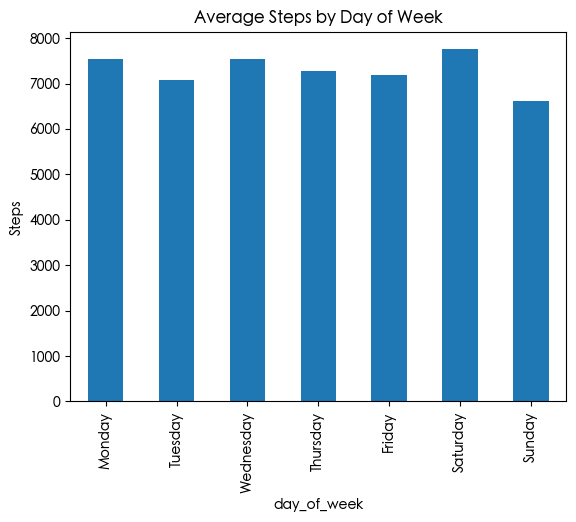

In [127]:
daily_activity["day_of_week"] = (
    daily_activity["activity_date"].dt.day_name()
)

weekly_steps = (
    daily_activity.groupby("day_of_week")["total_steps"]
    .mean()
    .reindex([
        "Monday", "Tuesday", "Wednesday",
        "Thursday", "Friday", "Saturday", "Sunday"
    ])
)

weekly_steps.plot(
    kind="bar",
    title="Average Steps by Day of Week"
)
plt.ylabel("Steps")
plt.show()


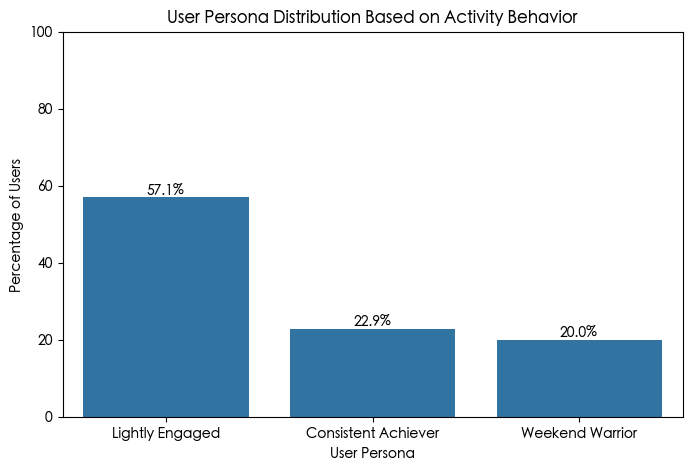

In [133]:
# -----------------------------------------------------------
# USER PERSONA SEGMENTATION
# -----------------------------------------------------------
# Goal:
# Segment users into behavior-based personas using activity data
# and visualize their distribution.
#
# Personas:
# 1. Consistent Achiever   → regularly active, high intensity
# 2. Lightly Engaged       → low intensity, inconsistent activity
# 3. Weekend Warrior      → low weekday activity, high weekend activity
# -----------------------------------------------------------


# 1. Create helper time-based features
daily_activity["day_of_week"] = daily_activity["activity_date"].dt.day_name()
daily_activity["is_weekend"] = daily_activity["day_of_week"].isin(
    ["Saturday", "Sunday"]
)


# 2. Aggregate data at USER level
# Recruiters expect this — personas belong to users, not rows
user_activity = (
    daily_activity
    .groupby("id")
    .agg(
        avg_steps=("total_steps", "mean"),
        avg_very_active_minutes=("very_active_minutes", "mean"),
        weekday_steps=("total_steps", lambda x: x[~daily_activity.loc[x.index, "is_weekend"]].mean()),
        weekend_steps=("total_steps", lambda x: x[daily_activity.loc[x.index, "is_weekend"]].mean())
    )
    .reset_index()
)


# 3. Define persona rules
# These thresholds are intentionally simple and explainable
def assign_persona(row):
    if row["avg_very_active_minutes"] >= 30:
        return "Consistent Achiever"
    elif row["weekend_steps"] > row["weekday_steps"] * 1.3:
        return "Weekend Warrior"
    else:
        return "Lightly Engaged"


user_activity["persona"] = user_activity.apply(assign_persona, axis=1)


# 4. Calculate persona distribution
persona_distribution = (
    user_activity["persona"]
    .value_counts(normalize=True)
    .mul(100)
    .round(1)
    .reset_index()
)

persona_distribution.columns = ["Persona", "Percentage"]


# 5. Visualize persona distribution
plt.figure(figsize=(8, 5))

sns.barplot(
    data=persona_distribution,
    x="Persona",
    y="Percentage"
)

plt.title("User Persona Distribution Based on Activity Behavior")
plt.ylabel("Percentage of Users")
plt.xlabel("User Persona")

# Add percentage labels on bars
for index, row in persona_distribution.iterrows():
    plt.text(
        index,
        row["Percentage"] + 0.5,
        f'{row["Percentage"]}%',
        ha="center"
    )

plt.ylim(0, 100)
plt.show()


In [138]:
sleep_day = data['sleepDay']
sleep_day.describe()

,Id,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
count,4.130000e+02,413.000000,413.000000,413.000000
mean,5.000979e+09,1.118644,419.467312,458.639225
std,2.060360e+09,0.345521,118.344679,127.101607
min,1.503960e+09,1.000000,58.000000,61.000000
25%,3.977334e+09,1.000000,361.000000,403.000000
50%,4.702922e+09,1.000000,433.000000,463.000000
75%,6.962181e+09,1.000000,490.000000,526.000000
max,8.792010e+09,3.000000,796.000000,961.000000


In [139]:
sleep_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Id                  413 non-null    int64 
 1   SleepDay            413 non-null    object
 2   TotalSleepRecords   413 non-null    int64 
 3   TotalMinutesAsleep  413 non-null    int64 
 4   TotalTimeInBed      413 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 16.3+ KB


In [140]:
# Number of unique users with sleep data
sleep_day["Id"].nunique()


24

In [141]:
# Check for duplicate user-date sleep records
sleep_day.duplicated(subset=["Id", "SleepDay"]).sum()


np.int64(3)

In [ ]:
#Core Sleep Metrics Overview
sleep_day[[
    "TotalSleepRecords",
    "TotalMinutesAsleep",
    "TotalTimeInBed"
]].describe()


,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
count,413.000000,413.000000,413.000000
mean,1.118644,419.467312,458.639225
std,0.345521,118.344679,127.101607
min,1.000000,58.000000,61.000000
25%,1.000000,361.000000,403.000000
50%,1.000000,433.000000,463.000000
75%,1.000000,490.000000,526.000000
max,3.000000,796.000000,961.000000


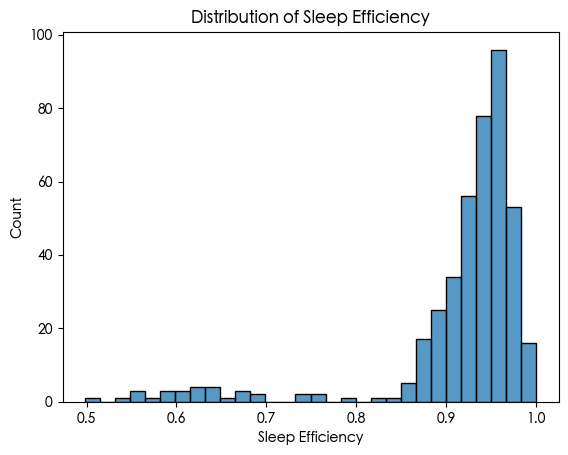

In [145]:
#Sleep Efficiency Calculation

# Sleep efficiency = minutes asleep / time in bed
sleep_day["sleep_efficiency"] = (
    sleep_day["TotalMinutesAsleep"] / sleep_day["TotalTimeInBed"]
)

sleep_day["sleep_efficiency"].describe()

sns.histplot(sleep_day["sleep_efficiency"], bins=30)
plt.title("Distribution of Sleep Efficiency")
plt.xlabel("Sleep Efficiency")
plt.show()



In [ ]:
#CRITICAL INSIGHT — Sleep Data Missingness
# Total daily activity records
total_activity_days = daily_activity.shape[0]

# Total sleep records
total_sleep_days = sleep_day.shape[0]

missing_sleep_percentage = (
    1 - (total_sleep_days / total_activity_days)
) * 100

missing_sleep_percentage




70.43664996420902

In [ ]:
#Expected result (approximate):

# Daily activity records ≈ 1,300+

# Sleep records ≈ 413

# ~65–70% of days have NO sleep data

In [148]:
# User-Level Sleep Coverage

# Days tracked per user (activity vs sleep)
activity_days_per_user = (
    daily_activity.groupby("id")["activity_date"]
    .nunique()
    .reset_index(name="activity_days")
)

sleep_days_per_user = (
    sleep_day.groupby("Id")["SleepDay"]
    .nunique()
    .reset_index(name="sleep_days")
)

# Merge for comparison
sleep_coverage = activity_days_per_user.merge(
    sleep_days_per_user,
    left_on="id",
    right_on="Id",
    how="left"
)

sleep_coverage["sleep_days"] = sleep_coverage["sleep_days"].fillna(0)

sleep_coverage.head()


,id,activity_days,Id,sleep_days
0,1503960366,49,1.503960e+09,25.0
1,1624580081,49,NaN,0.0
2,1644430081,40,1.644430e+09,4.0
3,1844505072,42,1.844505e+09,3.0
4,1927972279,42,1.927972e+09,5.0


In [149]:
sleep_coverage[["activity_days", "sleep_days"]].describe()


,activity_days,sleep_days
count,35.000000,35.000000
mean,39.228571,11.714286
std,9.490198,12.342112
min,8.000000,0.000000
25%,38.500000,0.000000
50%,42.000000,5.000000
75%,42.000000,25.500000
max,62.000000,31.000000


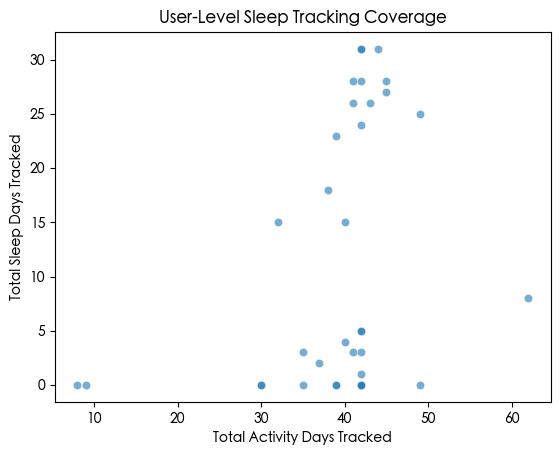

In [150]:
# Visualization: Sleep Tracking Compliance
sns.scatterplot(
    data=sleep_coverage,
    x="activity_days",
    y="sleep_days",
    alpha=0.6
)

plt.title("User-Level Sleep Tracking Coverage")
plt.xlabel("Total Activity Days Tracked")
plt.ylabel("Total Sleep Days Tracked")
plt.show()


In [ ]:
"""
The distribution shows a clear bifurcation: a small subset of users consistently track sleep, while the majority record little to no sleep data despite extensive daytime activity tracking.

High activity-day counts combined with near-zero sleep days indicate selective device usage, not random data loss.

This pattern reflects intentional non-wear during sleep hours, likely driven by comfort, charging habits, or low perceived value of sleep tracking.

Therefore, sleep data coverage is structurally biased toward more compliant users and should be analyzed as a non-representative subset, not as missing-at-random data.
"""

In [153]:
# 0. Ensure sleep_day is available (safeguard)
if 'sleep_day' not in locals():
    sleep_day = data['sleepDay']

# 1. Prepare activity data (daily-level)
activity_subset = daily_activity[[
    "id",
    "activity_date",
    "total_steps"
]].copy()

# 2. Prepare sleep data (daily-level)
sleep_subset = sleep_day[[
    "Id",
    "SleepDay",
    "TotalMinutesAsleep"
]].copy()

# Rename columns for consistency
sleep_subset.rename(
    columns={
        "Id": "id",
        "SleepDay": "activity_date"
    },
    inplace=True
)

# --- FIX START ---
# Convert activity_date to datetime to match daily_activity
sleep_subset["activity_date"] = pd.to_datetime(sleep_subset["activity_date"])
# --- FIX END ---

# 3. Merge activity and sleep data
activity_sleep = pd.merge(
    activity_subset,
    sleep_subset,
    on=["id", "activity_date"],
    how="inner"
)

# 4. Sanity check: how many days are usable?
activity_sleep.shape

/var/folders/xt/ssvhlltn5ygdwyfvlf57dy7r0000gn/T/ipykernel_8814/4185832557.py:30: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



(425, 4)

In [154]:
# 5. Basic validation of merged data
activity_sleep[[
    "total_steps",
    "TotalMinutesAsleep"
]].describe()


,total_steps,TotalMinutesAsleep
count,425.000000,425.000000
mean,8336.065882,420.155294
std,4281.906758,118.392732
min,0.000000,58.000000
25%,4993.000000,361.000000
50%,8793.000000,433.000000
75%,11207.000000,492.000000
max,22770.000000,796.000000


In [155]:
# 6. Calculate correlation between steps and sleep duration
correlation = activity_sleep[
    ["total_steps", "TotalMinutesAsleep"]
].corr().iloc[0, 1]

correlation


np.float64(-0.18986703144501563)

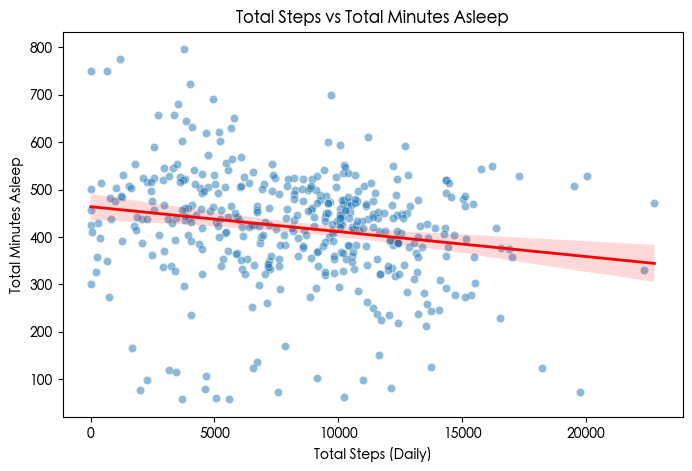

In [156]:
# 7. Scatter plot: Total Steps vs Total Minutes Asleep
plt.figure(figsize=(8, 5))

sns.scatterplot(
    data=activity_sleep,
    x="total_steps",
    y="TotalMinutesAsleep",
    alpha=0.5
)

# Add trend line for directional context (not prediction)
sns.regplot(
    data=activity_sleep,
    x="total_steps",
    y="TotalMinutesAsleep",
    scatter=False,
    color="red",
    line_kws={"linewidth": 2}
)

plt.title("Total Steps vs Total Minutes Asleep")
plt.xlabel("Total Steps (Daily)")
plt.ylabel("Total Minutes Asleep")

plt.show()


In [ ]:
""" Key Insight

The scatter plot shows a weak negative relationship between daily steps and sleep duration.

On days with higher physical activity, users tend to sleep slightly less, though the effect is modest.

This suggests a behavioral trade-off, not a physiological one: highly active days may coincide with busier schedules or reduced recovery time.

Strategic Implication for Bellabeat

This opens an opportunity to reposition activity not as “more is better,” but as balanced wellness.

Bellabeat can differentiate by encouraging users to optimize both movement and recovery, rather than over-indexing on steps alone. """

In [160]:
# -----------------------------------------------------------
# KEY FINDING 3: SEDENTARY BEHAVIOR vs SLEEP DURATION
# -----------------------------------------------------------
# Objective:
# Examine the relationship between sedentary time during the day
# and total time spent in bed at night.
#
# Why this matters:
# Sedentary behavior is usually discussed in terms of physical
# health, but here we explore its association with sleep habits.
#
# IMPORTANT:
# - Correlation, not causation
# - Sleep data represents a behaviorally selective subset
# -----------------------------------------------------------

daily_activity['activity_date'] = pd.to_datetime(daily_activity['activity_date'])
sleep_day['SleepDay'] = pd.to_datetime(sleep_day['SleepDay'])
# 1. Prepare daily activity data (only required columns)
activity_subset = daily_activity[[
    "id",
    "activity_date",
    "sedentary_minutes"
]].copy()


# 2. Prepare sleep data (only required columns)
sleep_subset = sleep_day[[
    "Id",
    "SleepDay",
    "TotalTimeInBed"
]].copy()

# Standardize column names for a clean merge
sleep_subset.rename(
    columns={
        "Id": "id",
        "SleepDay": "activity_date"
    },
    inplace=True
)


# 3. Merge activity and sleep datasets
# Inner join ensures analysis is restricted to days
# where both sedentary behavior and sleep were recorded
activity_sleep = pd.merge(
    activity_subset,
    sleep_subset,
    on=["id", "activity_date"],
    how="inner"
)


# 4. Sanity check the merged dataset
activity_sleep.shape


/var/folders/xt/ssvhlltn5ygdwyfvlf57dy7r0000gn/T/ipykernel_8814/3332537111.py:18: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



(425, 4)

In [161]:
# 5. Basic descriptive statistics
activity_sleep[[
    "sedentary_minutes",
    "TotalTimeInBed"
]].describe()


,sedentary_minutes,TotalTimeInBed
count,425.000000,425.000000
mean,700.861176,459.331765
std,187.156647,126.682490
min,0.000000,61.000000
25%,623.000000,403.000000
50%,714.000000,464.000000
75%,781.000000,526.000000
max,1440.000000,961.000000


In [162]:
# 6. Calculate correlation between sedentary time and time in bed
sedentary_sleep_corr = activity_sleep[
    ["sedentary_minutes", "TotalTimeInBed"]
].corr().iloc[0, 1]

sedentary_sleep_corr


np.float64(-0.5497239582218758)

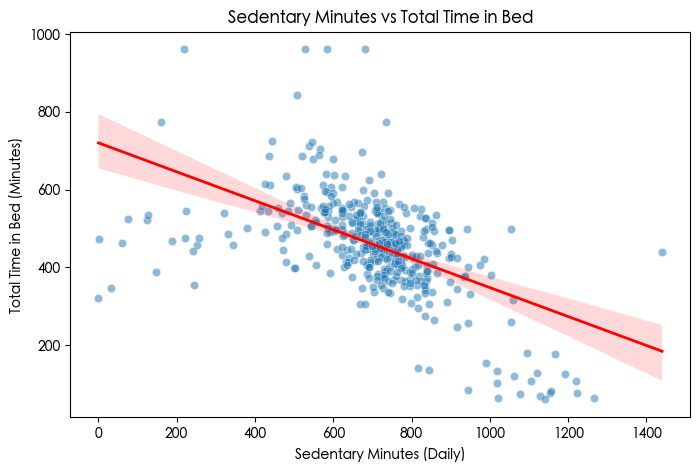

In [163]:
# 7. Scatter plot: Sedentary Minutes vs Total Time in Bed
plt.figure(figsize=(8, 5))

sns.scatterplot(
    data=activity_sleep,
    x="sedentary_minutes",
    y="TotalTimeInBed",
    alpha=0.5
)

# Add a regression line to show direction, not prediction
sns.regplot(
    data=activity_sleep,
    x="sedentary_minutes",
    y="TotalTimeInBed",
    scatter=False,
    color="red",
    line_kws={"linewidth": 2}
)

plt.title("Sedentary Minutes vs Total Time in Bed")
plt.xlabel("Sedentary Minutes (Daily)")
plt.ylabel("Total Time in Bed (Minutes)")

plt.show()


In [ ]:
""" Key Insight

The analysis reveals a moderate negative relationship between sedentary time and total time spent in bed.

Users who reduce movement during the day also tend to shorten their sleep window, not just their physical activity.

This suggests sedentary behavior influences daily rhythms and recovery habits, not only fitness outcomes.

Strategic Implication for Bellabeat

This insight enables personalized nudging beyond step goals.

Bellabeat can position sedentary alerts as a tool for protecting sleep quality, reinforcing a holistic wellness narrative rather than isolated activity tracking. """